In [1]:
%load_ext autoreload
%autoreload 3

In [3]:
import torch
import matplotlib.pyplot as plt
from flipper_training.engine.engine_config import PhysicsEngineConfig
from flipper_training.engine.robot_model import RobotModelConfig
from flipper_training.engine.engine import DPhysicsEngine, PhysicsState, PhysicsStateDer
from flipper_training.utils.dynamics import *
from flipper_training.utils.geometry import *
from flipper_training.utils.environment import *
from flipper_training.utils.numerical import *
from copy import deepcopy
from collections import deque

In [4]:
from flipper_training.vis.pltvis import *

In [5]:
torch.random.manual_seed(420)

In [6]:
# Heightmap setup - use torch's XY indexing !!!!!
grid_res = 0.05  # 5cm per grid cell
max_coord = 6.4  # meters
DIM = int(2 * max_coord / grid_res)
xint = torch.linspace(-max_coord, max_coord, DIM)
yint = torch.linspace(-max_coord, max_coord, DIM)
x, y = torch.meshgrid(xint, yint, indexing='xy')

In [7]:
num_robots = 1

In [8]:
# gaussian hm
z = (1.0 * torch.exp(-0.5 * ((x - 0)**2 + (y - 4)**2)) +
     0.0 * torch.exp(-0.3 * ((x - 1)**2 + (y + 2)**2)) +
     2.0 * torch.exp(-0.1 * ((x + max_coord)**2 + (y + max_coord)**2))
     ) + 0.01 * torch.randn_like(x) + torch.exp(-0.03 * ((x + 5)**2 + (y + 5)**2))
x_grid = x.repeat(num_robots, 1, 1)
y_grid = y.repeat(num_robots, 1, 1)
z_grid = z.repeat(num_robots, 1, 1)
x_grid.shape

torch.Size([1, 256, 256])

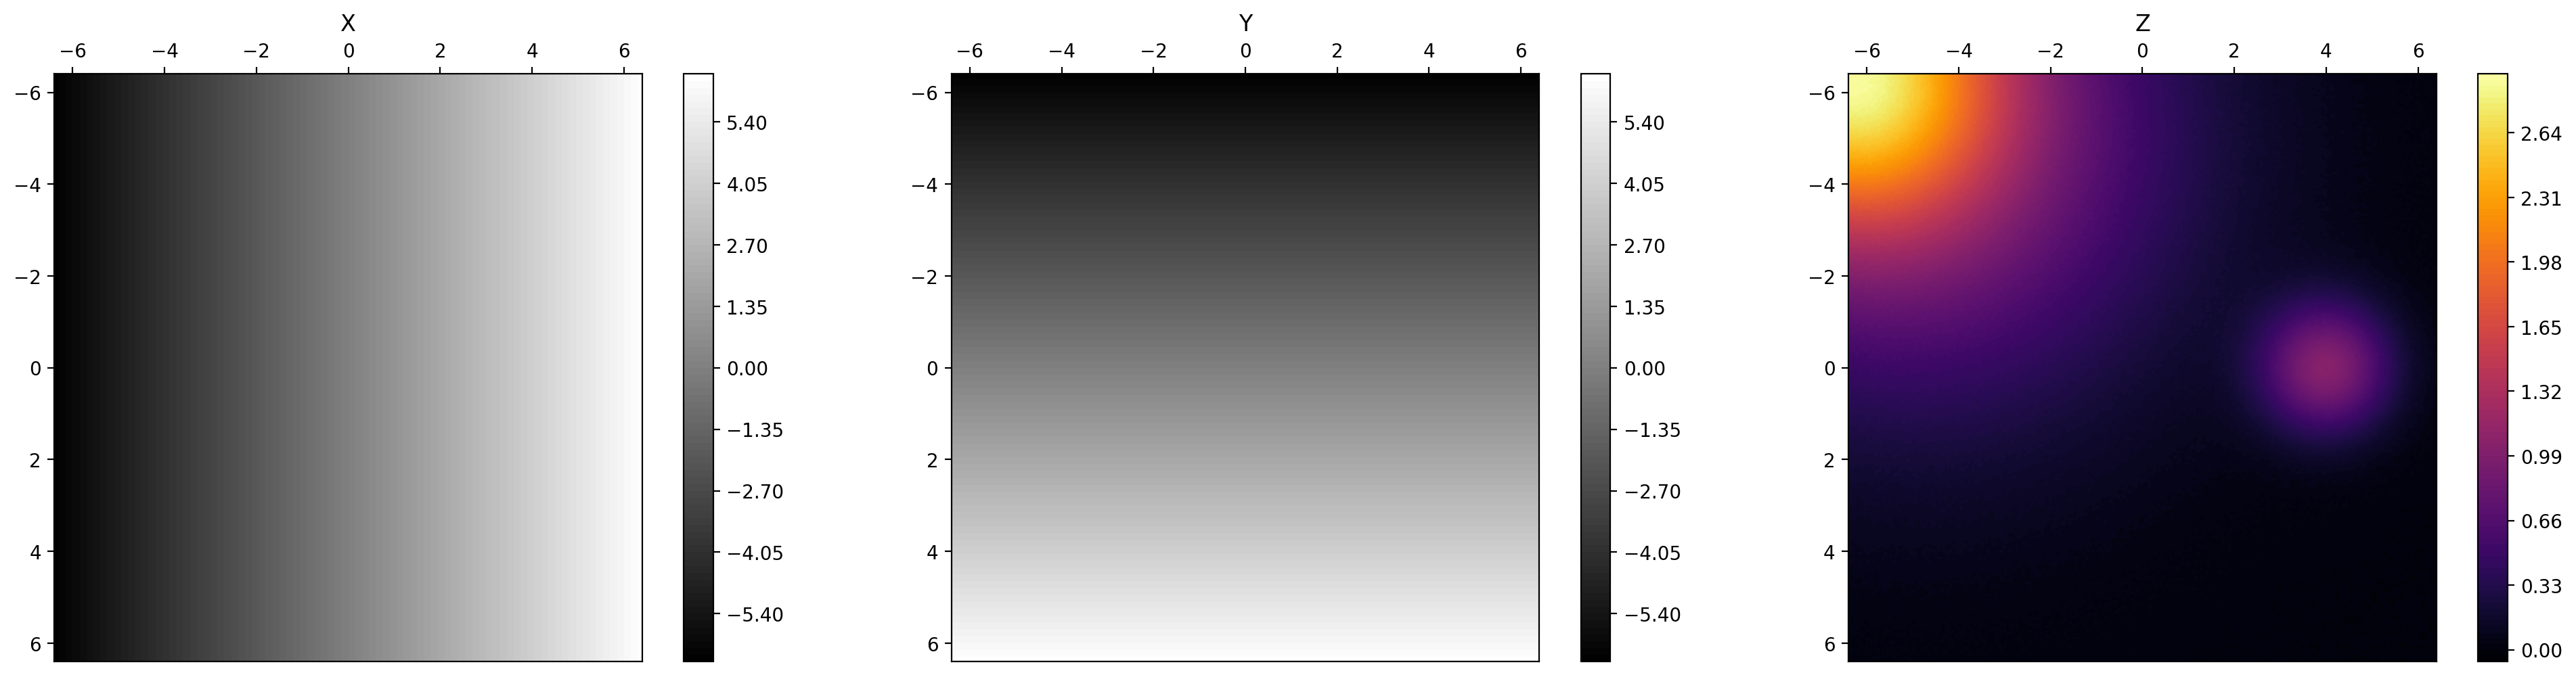

In [9]:
plot_grids_xyz(y_grid[0], x_grid[0], z_grid[0])

In [10]:
device = "cpu"

In [11]:
# Instatiate the physics config
robot_model = RobotModelConfig(robot_type="marv", voxel_size=0.08, points_per_driving_part=100)
physics_config = PhysicsEngineConfig(device=device, robot_model=robot_model, x_grid=x_grid, y_grid=y_grid, z_grid=z_grid, grid_res=grid_res, max_coord=max_coord, k_stiffness=30000)

Loading robot model from cache: /Users/davidkorcak/Documents/ctu/bachelors/flipper_training/.cache/marv_0.080_100.pt


In [12]:
# Controls
traj_length = 15.0  # seconds
n_iters = int(traj_length / physics_config.dt)
speed = 1.0  # m/s forward
omega = -0.5  # rad/s yaw
controls = physics_config.robot_model.get_controls(speed, omega)
flipper_controls = torch.zeros_like(controls)

In [13]:
engine = DPhysicsEngine(physics_config)

In [14]:
x0 = torch.tensor([-6, -6, 5.]).to(device).repeat(num_robots, 1)
xd0 = torch.zeros_like(x0)
R0 = torch.eye(3).to(device).repeat(num_robots, 1, 1)
omega0 = torch.zeros_like(x0)
thetas0 = torch.zeros(num_robots, 4).to(device)
local_robot_points0 = physics_config.robot_model.robot_points.to(device).repeat(num_robots, 1, 1)
controls_all = torch.cat((controls, flipper_controls)).unsqueeze(0).repeat(n_iters, num_robots, 1).to(device)

In [15]:
# Set joint rotational velocities, we want to follow a sine wave, so we set the joint velocities to the derivative of the sine wave
# We want to go +- pi/6 5 times in 10 seconds
amplitude = torch.pi / 3
periods = 2
rot_vels = torch.cos(torch.linspace(0, periods * 2 * np.pi, n_iters)) * amplitude
rot_vels = rot_vels.unsqueeze(-1).repeat(1, num_robots)
controls_all[:, :, len(controls)] = rot_vels
controls_all[:, :, len(controls) + 1] = rot_vels
controls_all[:, :, len(controls) + 2] = -rot_vels
controls_all[:, :, len(controls) + 3] = -rot_vels

In [16]:
init_state = PhysicsState(x0, xd0, R0, local_robot_points0, omega0, thetas0)

In [17]:
physics_config.robot_model.visualize_robot(local_robot_points0[0])

X: red, Y: green, Z: blue
Robot has 655 points


2024-12-22 23:22:20.688 Python[75234:14003080] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/yj/_6b0pqvs5xg33v_xy5q2v9_40000gn/T/org.python.python.savedState


Widget(value='<iframe src="http://localhost:64610/index.html?ui=P_0x3222daa90_0&reconnect=auto" class="pyvista…

In [18]:
bench_state = deepcopy(init_state)

In [19]:
compile = False

In [20]:
if compile:
    # run all torch compilation
    engine = torch.compile(engine)
    _ = engine(bench_state, controls_all[0])

In [21]:
%%timeit -o
_ = engine(bench_state, controls_all[0])

/Users/davidkorcak/Documents/ctu/bachelors/flipper_training/engine/engine.py:90: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  omega_d = torch.linalg.solve_ex(global_I, torque)[0]


28 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 28 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [22]:
states = deque(maxlen=n_iters)
dstates = deque(maxlen=n_iters)
auxs = deque(maxlen=n_iters)

In [23]:
%%time 
state = deepcopy(init_state)
i = 0
for ctrl in controls_all:
    state, der, aux = engine(state, ctrl)
    states.append(state)
    dstates.append(der)
    auxs.append(aux)
    i += 1

KeyboardInterrupt: 

: 

In [23]:
from flipper_training.engine.engine_state import vectorize_iter_of_tensor_tuples

In [24]:
states_vec = vectorize_iter_of_tensor_tuples(states)
dstates_vec = vectorize_iter_of_tensor_tuples(dstates)
aux_vec = vectorize_iter_of_tensor_tuples(auxs)

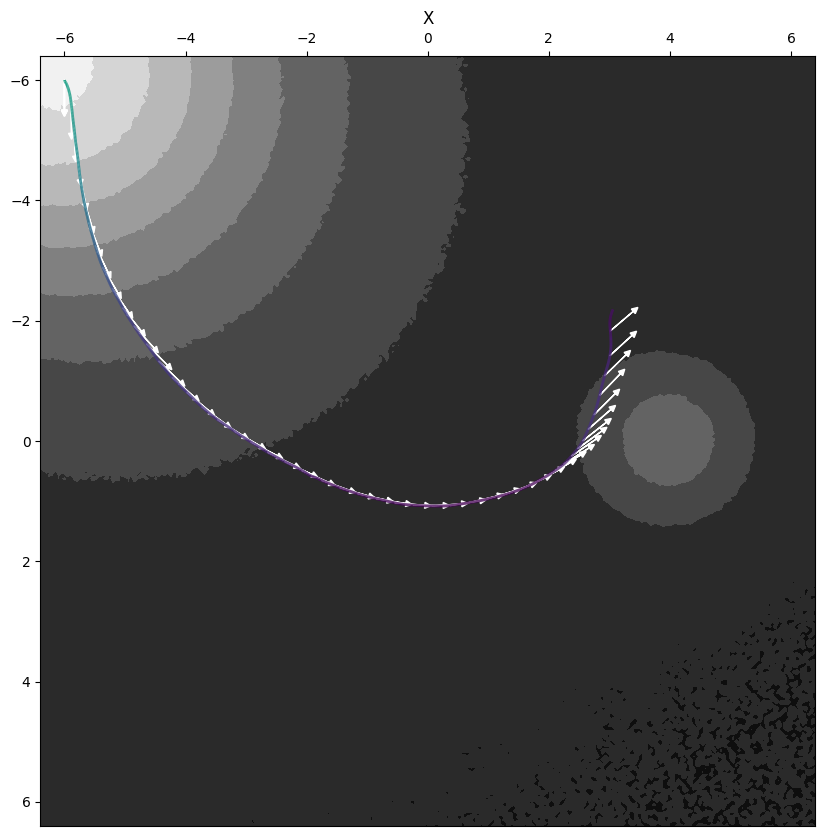

In [25]:
from matplotlib.collections import LineCollection

ROBOT_IDX = 0
ITERSTEP = 30
x_vis = x_grid[ROBOT_IDX].cpu().numpy()
y_vis = y_grid[ROBOT_IDX].cpu().numpy()
z_vis = z_grid[ROBOT_IDX].cpu().numpy()

# Heightmap plot
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
ax.contourf(y_vis, x_vis, z_vis, cmap='gray')
ax.invert_yaxis()
ax.set_title("X")
ax.xaxis.tick_top()  # Move X-axis ticks to the top
ax.tick_params(axis='x', labeltop=True, labelbottom=False)  # Show labels on top and hide them on bottom
xs, ys, zs = states_vec.x[:, ROBOT_IDX, :].T

for i in range(0, len(states_vec.x), ITERSTEP):
    pos = states_vec.x[i, ROBOT_IDX]
    yaw = yaw_from_R(states_vec.R[i, ROBOT_IDX].cpu())
    # plt.text(*pos[:2], str(i), fontsize=12, color='white')
    plt.arrow(pos[1], pos[0], 0.5 * torch.sin(yaw), 0.5 * torch.cos(yaw), head_width=0.1, head_length=0.1, fc='w', ec='w')

np_points = np.array([ys, xs]).T.reshape(-1, 1, 2)
segments = np.concatenate([np_points[:-1], np_points[1:]], axis=1)
lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(min(zs), max(zs)))
lc.set_array(np.array(zs))
lc.set_linewidth(2)
line = ax.add_collection(lc)

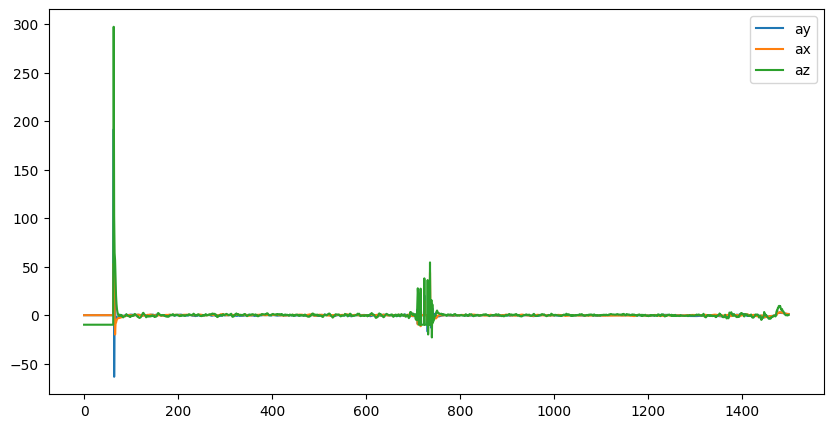

In [ ]:
# Plot components of acceleration
ay, ax, az = dstates_vec.xdd[:, ROBOT_IDX].T
plt.figure(figsize=(10, 5))
plt.plot(ay, label='ay')
plt.plot(ax, label='ax')
plt.plot(az, label='az')
plt.legend()

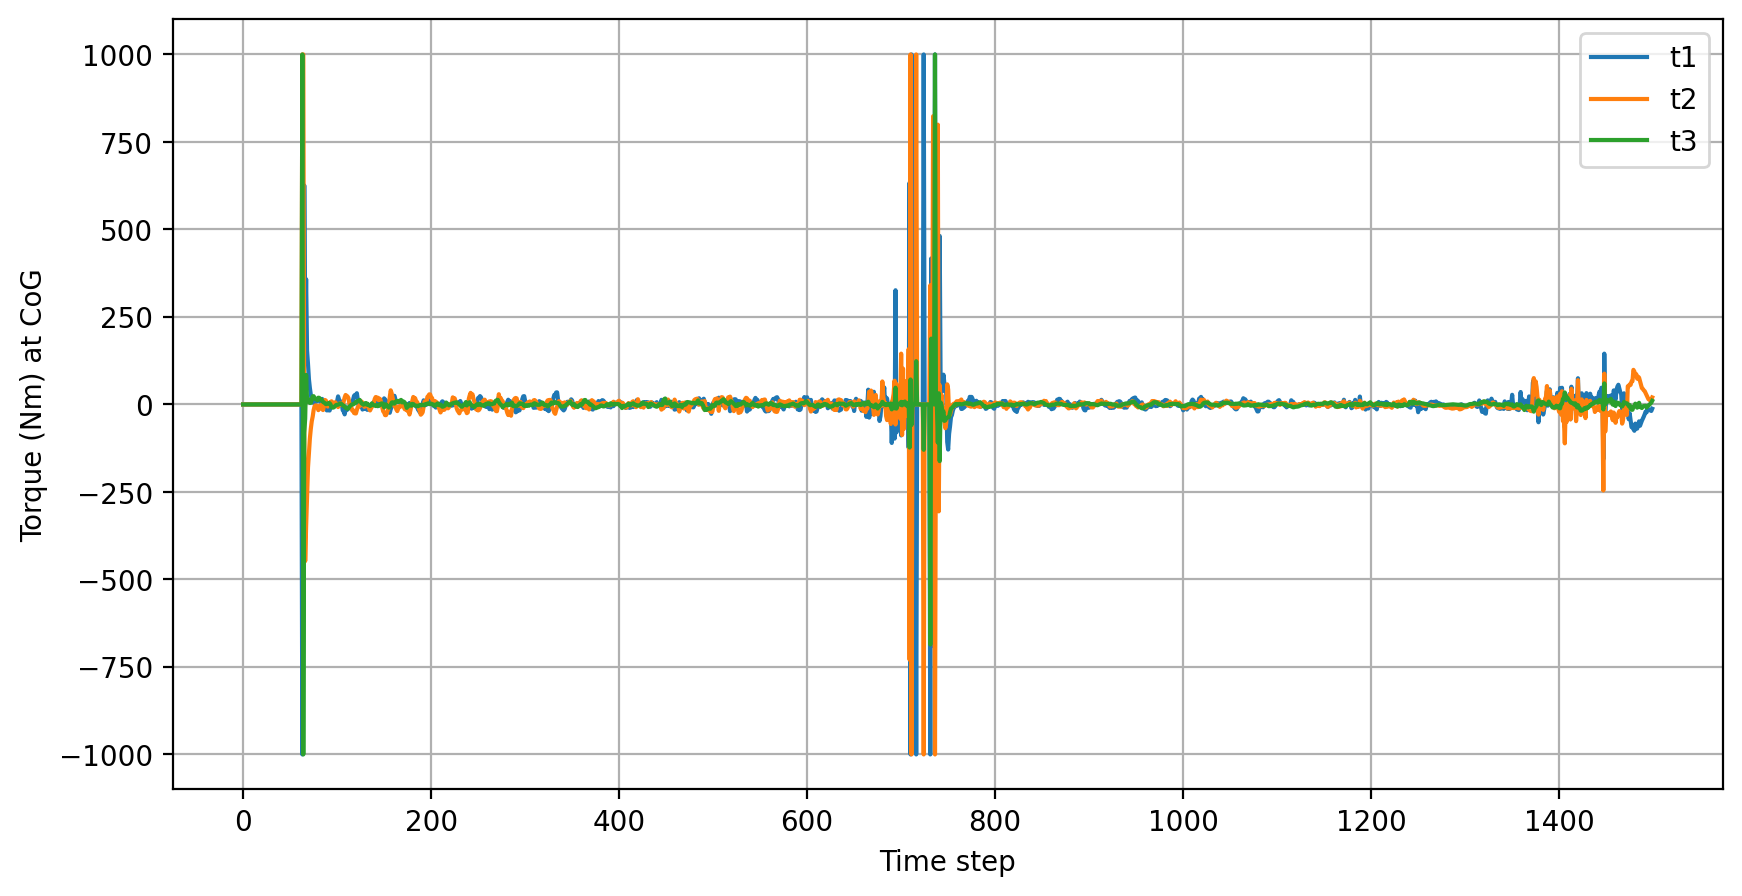

In [27]:
# Plot components of torque
t1, t2, t3 = aux_vec.torque[:, ROBOT_IDX].T
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(t1, label='t1')
plt.plot(t2, label='t2')
plt.plot(t3, label='t3')
plt.grid()
plt.xlabel('Time step')
plt.ylabel('Torque (Nm) at CoG')
plt.legend()

In [28]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'surface'}]])

# World

fig.add_trace(
    go.Surface(x=x_vis, y=y_vis, z=z_vis, colorscale='Viridis', showscale=False),
    row=1, col=1
)

# Trajectory

fig.add_trace(
    go.Scatter3d(x=xs, y=ys, z=zs, mode='lines', line=dict(color='red', width=5)),
)

# Robot pointcloud in last state

pts_global = aux_vec.global_robot_points[-1, ROBOT_IDX].cpu().numpy()
fig.add_trace(
    go.Scatter3d(x=pts_global[..., 0], y=pts_global[..., 1], z=pts_global[..., 2], mode='markers', marker=dict(size=5, color='blue')),
)

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Height (Z)',
        camera_eye=dict(x=1.25, y=1.25, z=1.25),
        aspectmode='manual',
        aspectratio=dict(
            x=1.,
            y=1.,
            z=zs.max().item() / (2 * max_coord)
        ),
    ),
    title_text='3D Heightmap',
)
fig.update_layout(
    width=1000,
    height=1000,
    margin=dict(l=20, r=20, t=20, b=20)
)

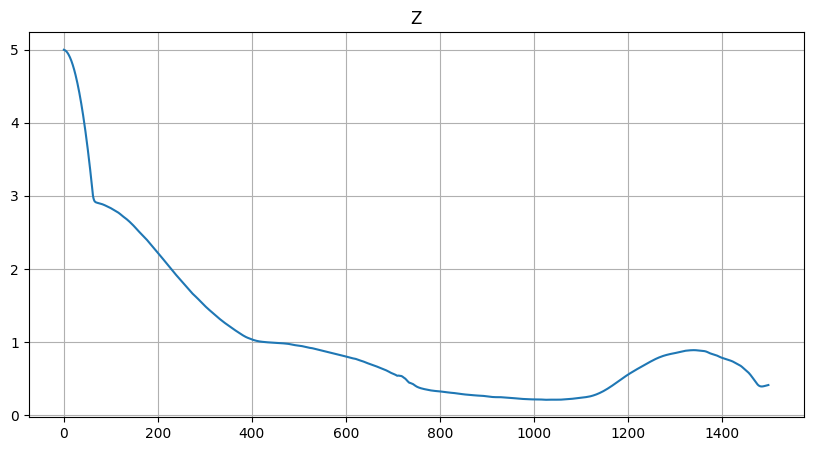

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.grid()
plt.title("Z")
plt.plot(zs)

In [30]:
from flipper_training.vis.visualizer import animate_trajectory

In [31]:
animate_trajectory(physics_config, states, auxs, 0)

2024-12-22 23:10:04.237 Python[71420:13978127] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-22 23:10:04.237 Python[71420:13978127] +[IMKInputSession subclass]: chose IMKInputSession_Modern
